In [2]:
# PROCESS THE GAIA CATALOG OF NEARBY STARS:
# https://cdsarc.cds.unistra.fr/viz-bin/cat/J/MNRAS/508/3877#/browse
#
#
# ZACK REEVES
# CREATED: 2024
#
# VERSIONS:
#  1.1  FEB 2024 CREATE JUPYTER NOTEBOOK

In [3]:
import pandas as pd
import numpy as np
import sys
import os
import collections

import astropy.units as u
import astropy.coordinates
from astropy.table import Table

from astroquery.gaia import Gaia

sys.path.insert(0, '..')
from common import file_functions, calculations

from matplotlib import pyplot as plt, colors

In [4]:
# Define the metadata for the data set. 
metadata = {}

metadata['project'] = 'Digital Universe Atlas Gaia Subsets'
metadata['sub_project'] = 'Gaia Catalog of Nearby Stars'

metadata['catalog'] = 'The Gaia Catalogue of Nearby Stars (Gaia Collaboration, 2021)'
metadata['catalog_author'] = 'Gaia Collaboration'
metadata['catalog_year'] = '2021'
metadata['catalog_doi'] = 'doi:10.1051/0004-6361/202039498'
metadata['catalog_bibcode'] = '2021A&A...649A...6G'

metadata['prepared_by'] = 'Brian Abbott, Zack Reeves'
metadata['version'] = '1.1'

metadata['dir'] = metadata['sub_project'].replace(' ', '_').lower()
metadata['raw_data_dir'] = ''

metadata['data_group_title'] = 'GCNS'
metadata['data_group_desc'] = 'Nearby stars in the Milky Way mapped by Gaia'
metadata['data_group_desc_long'] = 'Have you ever wondered what’s out there in space? Now, thanks to Gaia EDR3, the solar neighbourhood has been mapped with great precision out to 100 pc (326 light years)'
metadata['fileroot'] = 'gcns'

file_functions.generate_license_file(metadata)

In [5]:
# Define the metadata for the data set. ---- THIS IS OLD???
# metadata = {}

# metadata['project'] = 'Digital Universe Atlas Gaia Subsets'
# metadata['sub_project'] = 'Gaia Catalog of Nearby Stars'

# metadata['catalog'] = 'The Gaia Catalogue of Nearby Stars (Gaia Collaboration, 2021)'
# metadata['author'] = 'Gaia Collaboration'
# metadata['prepared_by'] = 'Zack Reeves (AMNH)'
# metadata['version'] = '1.1'

# metadata['dir'] = metadata['sub_project'].replace(' ', '_').lower()
# metadata['raw_data_dir'] = ''

# metadata['data_group_title'] = 'GCNS'
# metadata['data_group_desc'] = 'GCNS'
# metadata['fileroot'] = 'gcns'

In [6]:
#reading in the data

#log in to Gaia Server - Can change to different credentials file for a different user
Gaia.login(credentials_file='../common/gaia_credentials.txt')
    
#get username from credentials file for query
with open('../common/gaia_credentials.txt', 'r') as file:
    username = file.readline()

#Query Gaia DR3 source for parallaxes
#add distances and error
job = Gaia.launch_job_async("select a.source_id, a.ra, a.dec, a.dist_50, a.dist_16, a.dist_84, a.pmra, a.pmdec, a.adoptedrv as radial_velocity, "
                            "bj.r_med_geo, bj.r_hi_geo, bj.r_lo_geo, bj.r_med_photogeo, bj.r_hi_photogeo, bj.r_lo_photogeo, "
                            "c.phot_g_mean_mag, c.bp_g, c.teff_gspphot "
                            "from external.gaiaedr3_gcns_main_1 a inner join external.gaiaedr3_distance bj on a.source_id = bj.source_id "
                            "inner join gaiadr3.gaia_source c on a.source_id = c.source_id",
                            dump_to_file=False)

#Put the resulting table into a Table
data = job.get_results()
    
#Deleting job from Gaia ESA server so we don't clog the memory
Gaia.remove_jobs(job.jobid)

Gaia.logout()

INFO: Login to gaia TAP server [astroquery.gaia.core]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK
INFO: Query finished. [astroquery.utils.tap.core]
Removed jobs: '1761246679432O'.
INFO: Gaia TAP server logout OK [astroquery.gaia.core]
INFO: Gaia data server logout OK [astroquery.gaia.core]


In [7]:
data

source_id,ra,dec,dist_50,dist_16,dist_84,pmra,pmdec,radial_velocity,r_med_geo,r_hi_geo,r_lo_geo,r_med_photogeo,r_hi_photogeo,r_lo_photogeo,phot_g_mean_mag,bp_g,teff_gspphot
,deg,deg,kpc,kpc,kpc,mas / yr,mas / yr,km / s,pc,pc,pc,pc,pc,pc,mag,mag,K
int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
1964476435852285184,321.73545577510345,38.80185481181751,0.07107543,0.07068694,0.07147606,107.99049,-15.9268265,--,70.72699,71.121796,70.39486,70.79886,71.16038,70.45377,16.743237,1.1975975,--
1964476431552960384,321.73484561269504,38.80280764330452,0.070261426,0.06934677,0.07132117,104.95922,-13.734642,--,70.13264,71.03212,69.22599,70.15189,71.11146,69.22174,18.70563,0.8781128,--
1964512169975479296,320.93718364989024,38.80602000194771,0.09838999,0.09689944,0.10006338,55.60996,42.29026,--,98.22309,99.75195,96.49098,98.22153,99.79628,96.70574,18.638666,2.462614,--
1964898236001726080,320.3302026869608,38.75738848691011,0.0740729,0.07366628,0.07444975,64.893074,55.216976,--,73.767784,74.19395,73.46893,73.84363,74.28669,73.42836,13.941029,1.1971045,--
1964527838022391296,321.35640662301586,39.01935387782965,0.079854615,0.079630926,0.08008606,100.9212,62.198406,--,79.49633,79.683876,79.29889,79.5496,79.83607,79.29508,15.896627,1.576292,--
1964546254842234496,321.3329126792514,39.13638031026215,0.08741934,0.087329805,0.087513186,36.467663,7.3752875,--,87.14492,87.22152,87.04227,87.168976,87.26992,87.08038,13.414315,1.0953302,3800.589
1964578793510800256,321.8583392361685,39.07583472291407,0.10328376,0.101371974,0.10502967,53.016716,23.687834,--,102.647026,103.957664,101.08764,103.01701,104.68121,101.136856,14.572113,1.2501173,--
1964584428507876096,322.1028752956438,39.244334208388544,0.076595604,0.07648174,0.07670602,-150.84657,-117.50264,--,76.38646,76.50085,76.290855,76.37214,76.461914,76.27941,14.853022,1.2886047,3471.5679


In [8]:
# #read in stars.csv to remove the overlap?
# stars = Table.read('stars.csv')
# data.remove_rows([i for i in range(len(data)) if(data['source_id'][i] in stars['GaiaDR3'])])

In [9]:
len(data[data['teff_gspphot']>0])

125619

In [10]:
#setting dcalc based on r_med_geo (if>500pc and photogeo exists, we choose photogeo and set dcalc to 1, else geo and dcalc to 2)
data['dcalc'] = [1 if((not(np.ma.is_masked(data['r_med_photogeo'][i])))and(data['r_med_geo'][i]>500)) else 2 for i in range(len(data))]

#setting metadata for dcalc
data['dcalc'] = data.Column(data['dcalc'],
                            meta=collections.OrderedDict([('ucd', 'meta.dcalc')]),
                            description='Distance Indicator: 1 indicates a Bailer-Jones photogeometric distance; 2 indicates a Bailer-Jones geometric distance')

#Choosing distance based on dcalc
data['bj_distance'] = [data['r_med_photogeo'][i] if data['dcalc'][i]==1 else data['r_med_geo'][i] for i in range(len(data))]
data['bj_distance'].unit=u.pc

#Choosing and calculating distance error based on the distance we chose
data['e_bj_dist'] = [((data['r_hi_photogeo'][i]-data['r_lo_photogeo'][i])/2)*u.pc if((not(np.ma.is_masked(data['r_med_photogeo'][i])))and(data['r_med_geo'][i]>500)) else ((data['r_hi_geo'][i]-data['r_lo_geo'][i])/2)*u.pc for i in range(len(data))]

In [11]:
data.remove_rows(np.where(data['bj_distance']>500)[0])

In [12]:
#calculating distance in light years and parsecs
calculations.get_distance(data, dist='bj_distance', use='distance')

In [13]:
#calculating cartesian coordinates
calculations.get_cartesian(data, ra='ra', dec='dec', pmra='pmra', pmde='pmdec', radial_velocity='radial_velocity', frame='icrs')

In [14]:
#calculating absolute magnitudes
#calculate absolute V mag based on apparent magnitude and distance
data['appmag'] = data.MaskedColumn(data=data['phot_g_mean_mag'],
                             unit=u.mag,
                             meta=collections.OrderedDict([('ucd', 'phot.mag;em.opt.G')]),
                             format='{:.6f}',
                             description='Apparent magnitude in Gaia G-band')
data['absmag'] = data.MaskedColumn(data=[data['appmag'][i]+5-5*np.log10(data['dist_pc'][i]) for i in range(len(data))],
                             unit=u.mag,
                             meta=collections.OrderedDict([('ucd', 'phot.magAbs;em.opt.G')]),
                             format='{:.6f}',
                             description='Absolute magnitude in Gaia G-band')

c:\Users\cadem\anaconda3\envs\du_env\Lib\site-packages\numpy\ma\core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\cadem\anaconda3\envs\du_env\Lib\site-packages\astropy\table\column.py:558: UserWarning: Warning: converting a masked element to nan.
  self_data = np.array(data, dtype=dtype, copy=copy)


In [15]:
#calculate luminosity based on absolute magnitude
data['lum'] = [10**(1.89 - 0.4*data['absmag'][i]) for i in range(len(data))]
small_luminosities = np.where((data['lum']>0.0) & (data['lum']<0.001))[0]
data['lum'][small_luminosities] = [0.001]*len(small_luminosities)

data['lum'] = data.MaskedColumn(data=data['lum'],
                             unit=u.solLum,
                             meta=collections.OrderedDict([('ucd', 'phys.luminosity')]),
                             format='{:.6f}',
                             description='Stellar Luminosity')

In [16]:
data.columns

<TableColumns names=('source_id','ra','dec','dist_50','dist_16','dist_84','pmra','pmdec','radial_velocity','r_med_geo','r_hi_geo','r_lo_geo','r_med_photogeo','r_hi_photogeo','r_lo_photogeo','phot_g_mean_mag','bp_g','teff_gspphot','dcalc','bj_distance','e_bj_dist','dist_pc','dist_ly','x','y','z','u','v','w','speed','appmag','absmag','lum')>

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        2.000e+00, 3.000e+00, 1.000e+00, 3.000e+00, 1.000e+00, 3.000e+00,
        2.000e+00, 1.000e+00, 5.000e+00, 0.000e+00, 1.000e+00, 5.000e+00,
        5.000e+00, 5.000e+00, 2.000e+00, 2.000e+00, 5.000e+00, 6.000e+00,
        3.000e+00, 2.000e+00, 2.000e+00, 7.000e+00, 8.000e+00, 3.000e+00,
        2.000e+00, 6.000e+00, 5.000e+00, 8.000e+00, 9.000e+00, 8.000e+00,
        4.000e+00, 1.000e+01, 7.000e+0

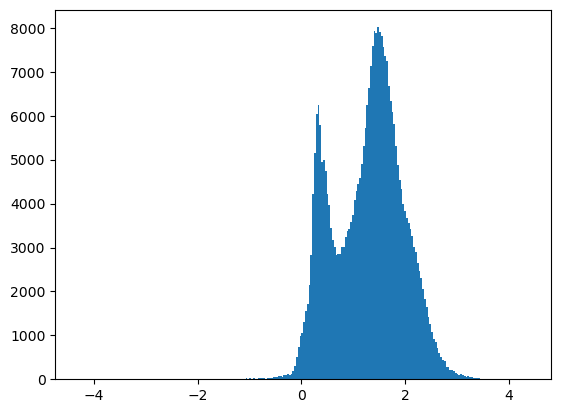

In [17]:
#setting color and visualizing
data['color'] = data.MaskedColumn(data=data['bp_g'],
                             unit=u.solLum,
                             meta=collections.OrderedDict([('ucd', 'phys.color')]),
                             format='{:.2f}',
                             description='Gaia BP-G color')
plt.hist(data['color'], bins=250)

<function matplotlib.pyplot.show(close=None, block=None)>

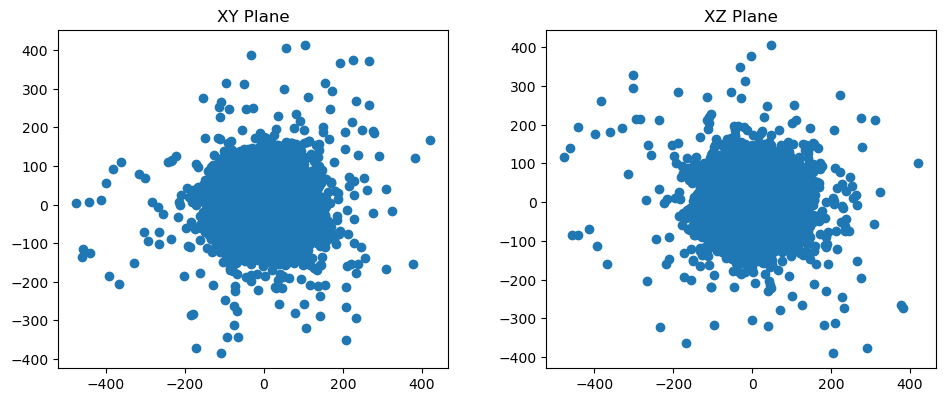

In [18]:
#2D Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].scatter(data['x'], data['y'])
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].scatter(data['x'], data['z'])
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
plt.show

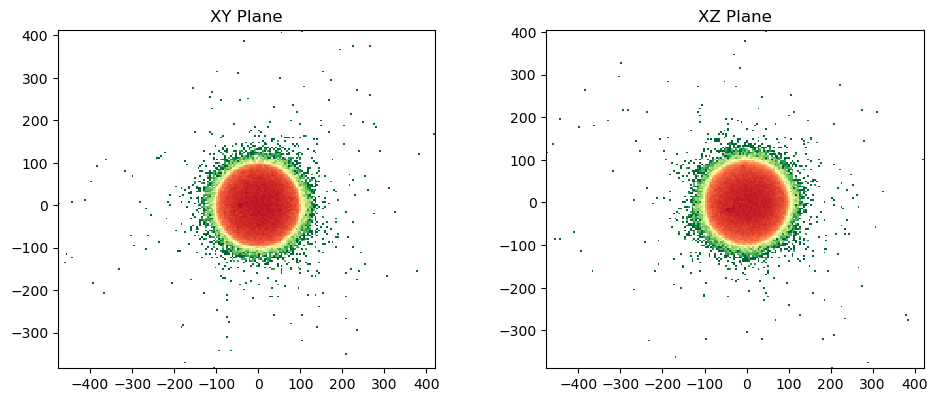

In [19]:
#2D Density Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].hist2d(data['x'], data['y'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].hist2d(data['x'], data['z'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
#plt.show

In [20]:
#construct a speck comment column
data['speck_label'] = data.Column(data=['#__'+str(name) for name in data['source_id']], 
                                  meta=collections.OrderedDict([('ucd', 'meta.id')]),
                                  description='Gaia EDR3 Source ID')

#construct a label column
data['label'] = ['GaiaEDR3_'+ str(source) for source in data['source_id']]  #leaving for now in case we want to add other labels

In [21]:
#setting texture number column
data['texnum'] = data.Column(data=[1]*len(data), 
                                  meta=collections.OrderedDict([('ucd', 'meta.texnum')]),
                                  description='Texture Number')

In [22]:
#Getting the column metadata
columns = file_functions.get_metadata(data, columns=['x', 'y', 'z', 'color', 'lum', 'absmag', 'appmag', 'texnum', 'dist_ly', 'dcalc', 'u', 'v', 'w', 'speed', 'speck_label'])
columns

,name,unit,datatype,width,precision,arraysize,ucd,description
0,x,pc,float64,,6,,pos.cartesian.x,x position (galactic cartesian coordinates) in...
1,y,pc,float64,,6,,pos.cartesian.y,Position (y coordinate) in parsecs
2,z,pc,float64,,6,,pos.cartesian.z,Position (z coordinate) in parsecs
3,color,solLum,float32,,2,,phys.color,Gaia BP-G color
4,lum,solLum,float64,,6,,phys.luminosity,Stellar Luminosity
5,absmag,mag,float64,,6,,phot.magAbs;em.opt.G,Absolute magnitude in Gaia G-band
6,appmag,mag,float32,,6,,phot.mag;em.opt.G,Apparent magnitude in Gaia G-band
7,texnum,,int32,,,,meta.texnum,Texture Number
8,dist_ly,lyr,float32,,1,,pos.distance,Distance from Sun (lyr)
9,dcalc,,int32,,,,meta.dcalc,Distance Indicator: 1 indicates a Bailer-Jones...


In [23]:
# #construct a metadata table
# columns = file_functions.get_metadata(data, columns=['x', 'y', 'z', 'dist_ly', 'u', 'v', 'w', 'speck_label'])
# columns

In [24]:
# Print the csv file using the to_csv function in file_functions
file_functions.to_csv(metadata, Table.to_pandas(data), columns)

In [25]:
# Print the speck file using the to_speck function in file_functions
file_functions.to_speck(metadata, Table.to_pandas(data), columns)

In [26]:
# Print the label file using the to_label function in file_functions
file_functions.to_label(metadata, Table.to_pandas(data))